Usando dispositivo: cuda
Cargando dataset CIFAR-10...
Files already downloaded and verified
Forma del dataset: (50000, 3, 32, 32)
¡Dataset cargado exitosamente! (Sin etiquetas originales)


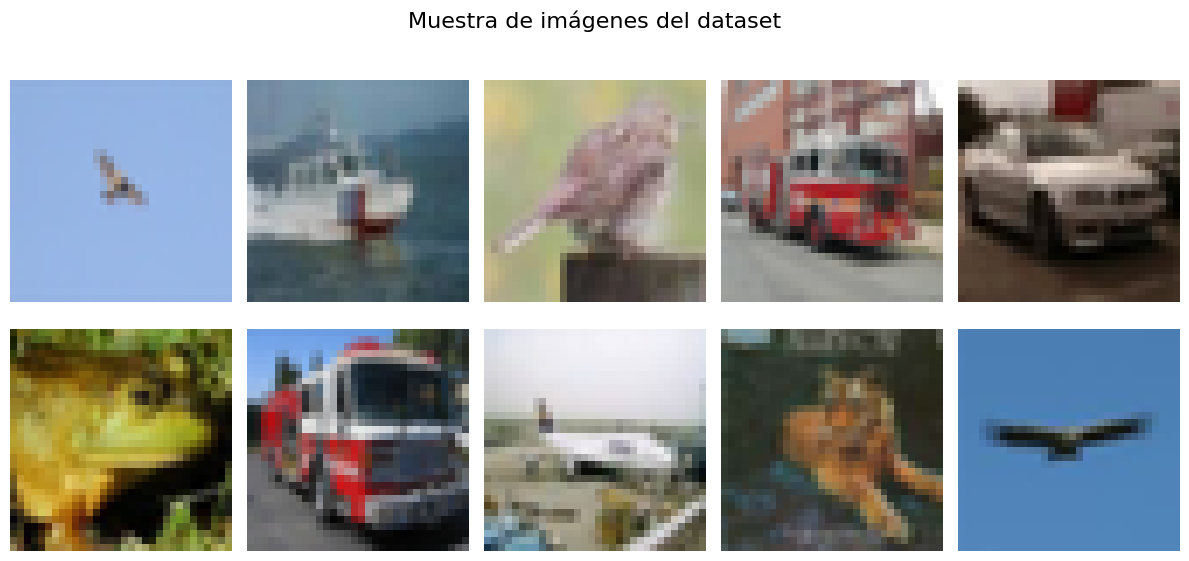

In [1]:
# PARTE 1: IMPORTACIONES Y CARGA DE DATOS
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Transformaciones para mejorar la calidad de las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalización
])

# Cargar CIFAR-10 (solo necesitamos las imágenes, NO las etiquetas originales)
print("Cargando dataset CIFAR-10...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

# Extraer solo las imágenes (ignorando completamente las etiquetas originales)
images = []
for i in range(50000):  
    image, _ = trainset[i]  
    images.append(image.numpy())

images = np.array(images)
print(f"Forma del dataset: {images.shape}")
print("¡Dataset cargado exitosamente! (Sin etiquetas originales)")

# Función para visualizar imágenes
def mostrar_imagenes(imagenes, titulo="Imágenes", filas=2, columnas=5):
    fig, axes = plt.subplots(filas, columnas, figsize=(12, 6))
    fig.suptitle(titulo, fontsize=16)
    
    for i in range(filas * columnas):
        if i < len(imagenes):
            ax = axes[i // columnas, i % columnas] if filas > 1 else axes[i]
            # Convertir de tensor normalizado a imagen visualizable
            img = imagenes[i].transpose(1, 2, 0)
            img = (img + 1) / 2  # Desnormalizar
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar algunas imágenes de muestra
indices_muestra = random.sample(range(50000), 10)
imagenes_muestra = [images[i] for i in indices_muestra]
mostrar_imagenes(imagenes_muestra, "Muestra de imágenes del dataset")

Iniciando mejora de calidad de imágenes...
Mejorando calidad de imágenes...
Procesando imagen 0/50000
Procesando imagen 10000/50000
Procesando imagen 20000/50000
Procesando imagen 30000/50000
Procesando imagen 40000/50000

Comparación: Antes vs Después de mejora de calidad


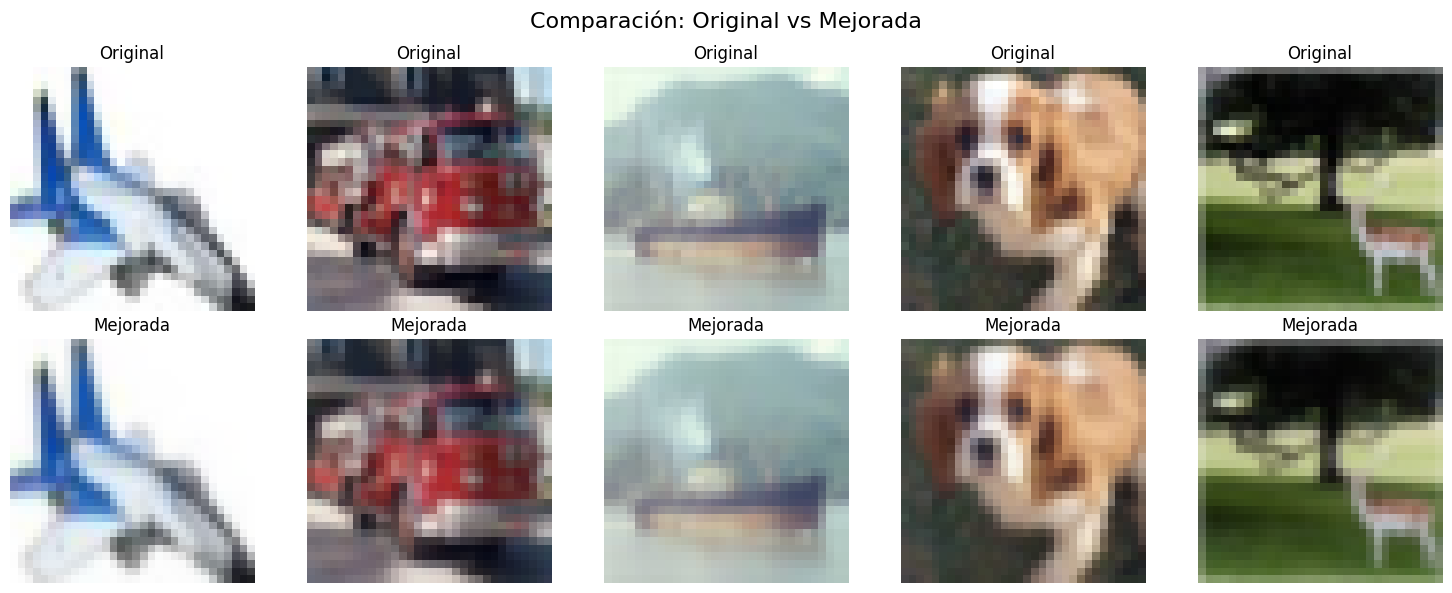

Preparando datos para clustering...
Dimensiones después de aplanar: (50000, 3072)
Datos normalizados
Aplicando PCA para reducir de 3072 a 200 características...
Dimensiones finales: (50000, 200)

¡Datos preparados para clustering!
- 50000 imágenes procesadas
- Características reducidas de 3072 a 200
- Datos listos para K-means


In [2]:
# PARTE 2: PREPROCESAMIENTO Y REDUCCIÓN DE CARACTERÍSTICAS

def mejorar_calidad_imagenes(imagenes):
    """
    Mejora la calidad de las imágenes aplicando filtros de suavizado
    """
    from scipy import ndimage
    imagenes_mejoradas = []
    
    print("Mejorando calidad de imágenes...")
    for i, img in enumerate(imagenes):
        if i % 10000 == 0:
            print(f"Procesando imagen {i}/{len(imagenes)}")
        
        # Aplicar filtro gaussiano para reducir pixelado
        img_mejorada = np.zeros_like(img)
        for canal in range(3):
            img_mejorada[canal] = ndimage.gaussian_filter(img[canal], sigma=0.5)
        
        imagenes_mejoradas.append(img_mejorada)
    
    return np.array(imagenes_mejoradas)

def preparar_datos_para_clustering(imagenes, n_componentes_pca=200):
    """
    Prepara los datos para clustering:
    1. Aplana las imágenes
    2. Normaliza los datos
    3. Aplica PCA para reducir dimensionalidad
    """
    print("Preparando datos para clustering...")
    
    # Aplanar las imágenes (3, 32, 32) -> (3072,)
    X = imagenes.reshape(len(imagenes), -1)
    print(f"Dimensiones después de aplanar: {X.shape}")
    
    # Normalizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Datos normalizados")
    
    # Aplicar PCA para reducir dimensionalidad
    print(f"Aplicando PCA para reducir de {X_scaled.shape[1]} a {n_componentes_pca} características...")
    pca = PCA(n_components=n_componentes_pca, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"Dimensiones finales: {X_pca.shape}")
    
    return X_pca, scaler, pca

# Mejorar calidad de imágenes
print("Iniciando mejora de calidad de imágenes...")
images_mejoradas = mejorar_calidad_imagenes(images)

# Comparar antes y después
print("\nComparación: Antes vs Después de mejora de calidad")
indices_comparacion = random.sample(range(50000), 5)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Comparación: Original vs Mejorada', fontsize=16)

for i, idx in enumerate(indices_comparacion):
    # Original
    img_orig = images[idx].transpose(1, 2, 0)
    img_orig = (img_orig + 1) / 2
    img_orig = np.clip(img_orig, 0, 1)
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    # Mejorada
    img_mej = images_mejoradas[idx].transpose(1, 2, 0)
    img_mej = (img_mej + 1) / 2
    img_mej = np.clip(img_mej, 0, 1)
    axes[1, i].imshow(img_mej)
    axes[1, i].set_title('Mejorada')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Preparar datos para clustering (usar imágenes mejoradas)
X_preparado, scaler, pca = preparar_datos_para_clustering(images_mejoradas)

print(f"\n¡Datos preparados para clustering!")
print(f"- {len(images_mejoradas)} imágenes procesadas")
print(f"- Características reducidas de 3072 a {X_preparado.shape[1]}")
print(f"- Datos listos para K-means")

Seleccionando muestra aleatoria de 10,000 imágenes para optimización de K...
Muestra seleccionada: (10000, 200)

Iniciando análisis para encontrar el K óptimo...
Calculando métricas para diferentes valores de K...
Probando K = 2...
Probando K = 3...
Probando K = 4...
Probando K = 5...
Probando K = 6...
Probando K = 7...
Probando K = 8...
Probando K = 9...
Probando K = 10...
Probando K = 11...
Probando K = 12...
Probando K = 13...
Probando K = 14...
Probando K = 15...

Graficando resultados...


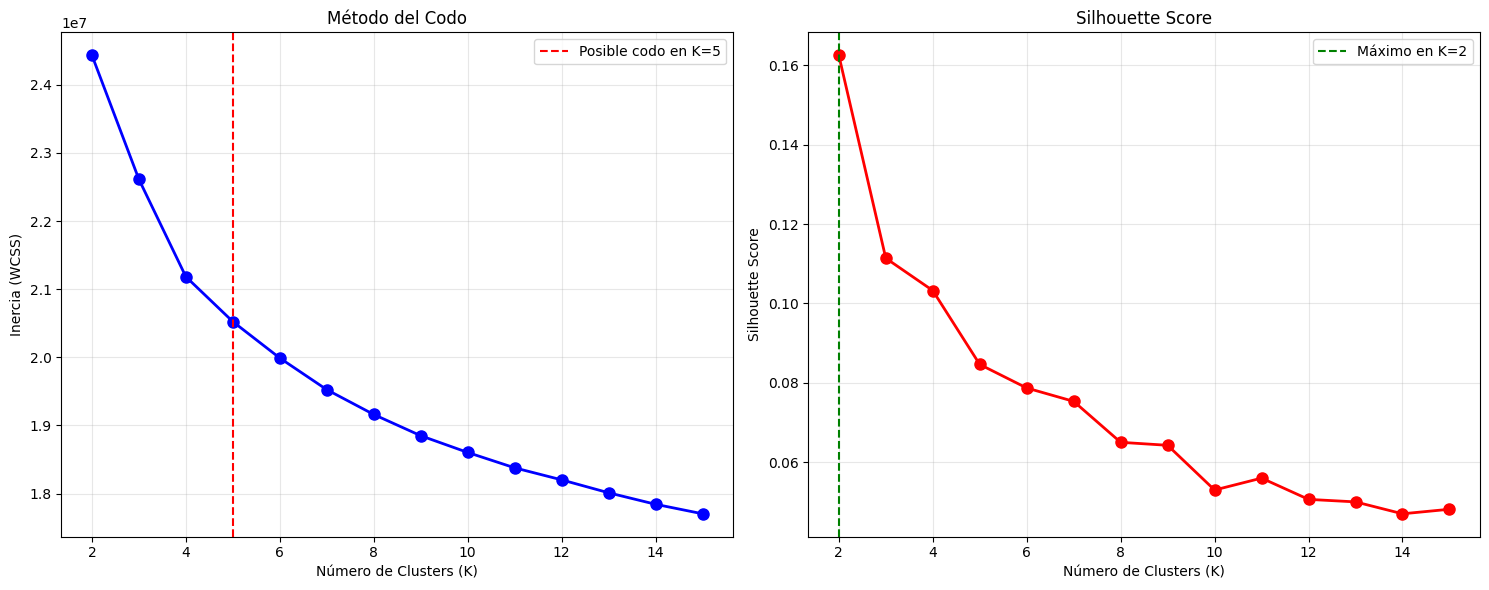


=== RECOMENDACIONES PARA K ===
K con mejor Silhouette Score: 2
Silhouette Score máximo: 0.163

Tabla completa de resultados:
     K     Inercia  Silhouette Score
0    2  24434476.0             0.163
1    3  22612722.0             0.111
2    4  21182786.0             0.103
3    5  20523450.0             0.085
4    6  19988886.0             0.079
5    7  19524576.0             0.075
6    8  19160312.0             0.065
7    9  18848672.0             0.064
8   10  18602906.0             0.053
9   11  18377050.0             0.056
10  12  18200558.0             0.051
11  13  18010736.0             0.050
12  14  17841834.0             0.047
13  15  17702376.0             0.048

=== SELECCIÓN DE K ===
Basado en el análisis, se recomienda K = 2
Puedes cambiar este valor en la siguiente celda si deseas usar otro K.


In [3]:
# PARTE 3: OPTIMIZACIÓN DE K-MEANS (MÉTODO DEL CODO Y SILHOUETTE)

def seleccionar_muestra_kmeans(X, n_muestras=10000):
    """
    Selecciona una muestra aleatoria para optimización de K-means
    """
    indices = random.sample(range(len(X)), n_muestras)
    return X[indices], indices

def metodo_codo_y_silhouette(X_muestra, rango_k=range(2, 21)):
    """
    Implementa el método del codo y silhouette score para encontrar el K óptimo
    """
    inercias = []
    silhouette_scores = []
    k_values = list(rango_k)
    
    print("Calculando métricas para diferentes valores de K...")
    
    for k in k_values:
        print(f"Probando K = {k}...")
        
        # Ejecutar K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        etiquetas = kmeans.fit_predict(X_muestra)
        
        # Calcular inercia (para método del codo)
        inercias.append(kmeans.inertia_)
        
        # Calcular silhouette score
        if len(np.unique(etiquetas)) > 1:  # Necesitamos al menos 2 clusters
            sil_score = silhouette_score(X_muestra, etiquetas)
            silhouette_scores.append(sil_score)
        else:
            silhouette_scores.append(-1)
    
    return k_values, inercias, silhouette_scores

def graficar_metricas_k(k_values, inercias, silhouette_scores):
    """
    Grafica el método del codo y silhouette scores
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Método del codo
    ax1.plot(k_values, inercias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Número de Clusters (K)')
    ax1.set_ylabel('Inercia (WCSS)')
    ax1.set_title('Método del Codo')
    ax1.grid(True, alpha=0.3)
    
    # Encontrar el "codo" aproximado
    # Calcular la segunda derivada
    if len(inercias) >= 3:
        segunda_derivada = np.diff(inercias, 2)
        codo_idx = np.argmax(segunda_derivada) + 2
        if codo_idx < len(k_values):
            ax1.axvline(x=k_values[codo_idx], color='red', linestyle='--', 
                       label=f'Posible codo en K={k_values[codo_idx]}')
            ax1.legend()
    
    # Silhouette Score
    ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Número de Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score')
    ax2.grid(True, alpha=0.3)
    
    # Marcar el máximo silhouette score
    max_sil_idx = np.argmax(silhouette_scores)
    ax2.axvline(x=k_values[max_sil_idx], color='green', linestyle='--',
               label=f'Máximo en K={k_values[max_sil_idx]}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return k_values[max_sil_idx]

# Seleccionar muestra de 10,000 imágenes para optimización
print("Seleccionando muestra aleatoria de 10,000 imágenes para optimización de K...")
X_muestra, indices_muestra = seleccionar_muestra_kmeans(X_preparado, 10000)
print(f"Muestra seleccionada: {X_muestra.shape}")

# Ejecutar método del codo y silhouette
print("\nIniciando análisis para encontrar el K óptimo...")
k_values, inercias, silhouette_scores = metodo_codo_y_silhouette(X_muestra, range(2, 16))

# Graficar resultados
print("\nGraficando resultados...")
k_optimo_sil = graficar_metricas_k(k_values, inercias, silhouette_scores)

# Mostrar recomendaciones
print(f"\n=== RECOMENDACIONES PARA K ===")
print(f"K con mejor Silhouette Score: {k_optimo_sil}")
print(f"Silhouette Score máximo: {max(silhouette_scores):.3f}")

# Crear tabla de resultados
import pandas as pd
resultados_df = pd.DataFrame({
    'K': k_values,
    'Inercia': inercias,
    'Silhouette Score': silhouette_scores
})

print("\nTabla completa de resultados:")
print(resultados_df.round(3))

# Permitir que el usuario elija K
print(f"\n=== SELECCIÓN DE K ===")
print(f"Basado en el análisis, se recomienda K = {k_optimo_sil}")
print("Puedes cambiar este valor en la siguiente celda si deseas usar otro K.")

Aplicando K-means con K = 2...
Ejecutando K-means con K=2 en 50000 imágenes...

=== ESTADÍSTICAS DE CLUSTERING ===
Número total de imágenes: 50000
Número de clusters: 2

Distribución por cluster:
Cluster 0: 21635 imágenes (43.3%)
Cluster 1: 28365 imágenes (56.7%)

Generando visualización 2D de los clusters...


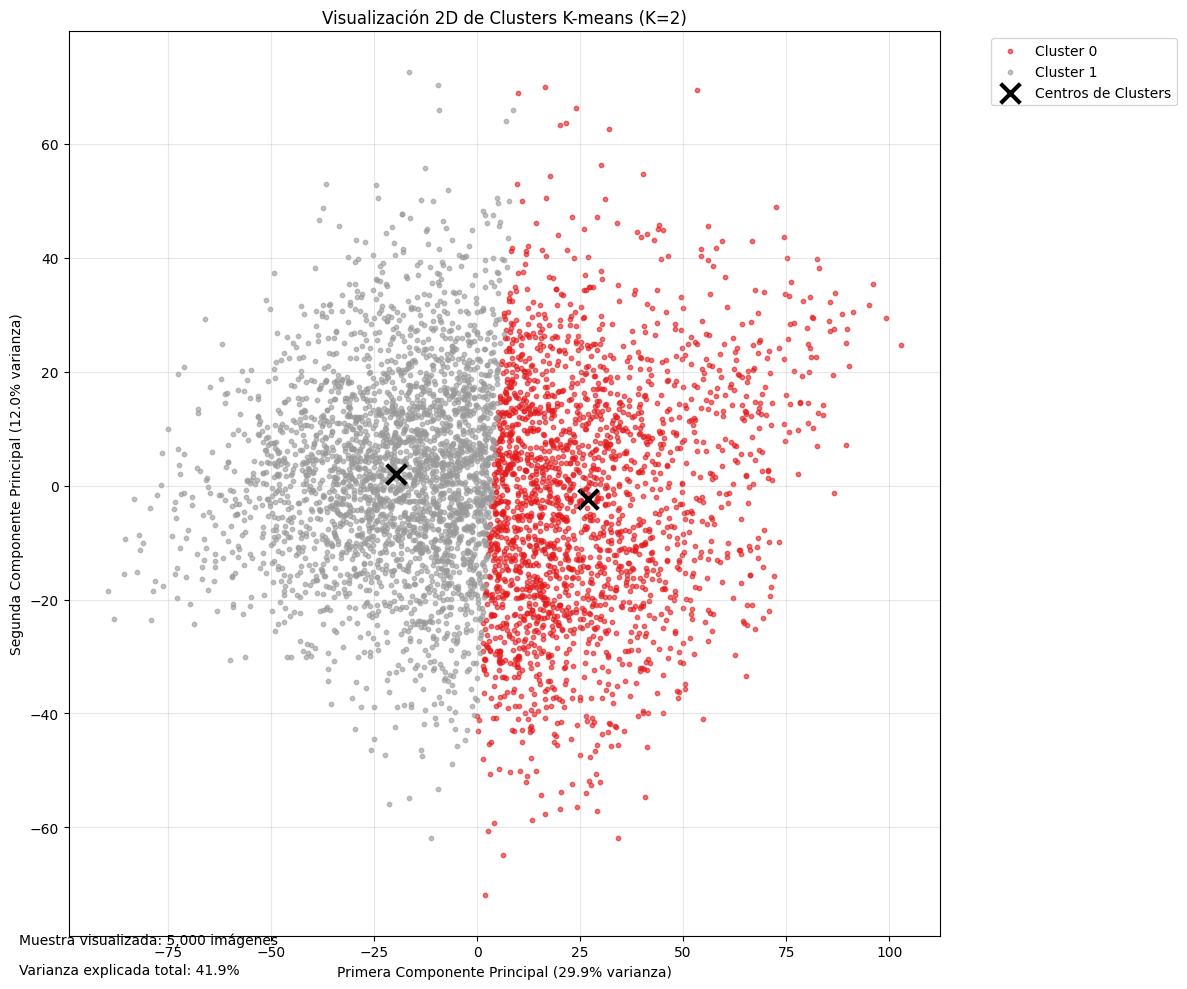

Varianza explicada por las 2 componentes principales: 41.9%

Encontrando imágenes representativas de cada cluster...

Visualizando clusters...


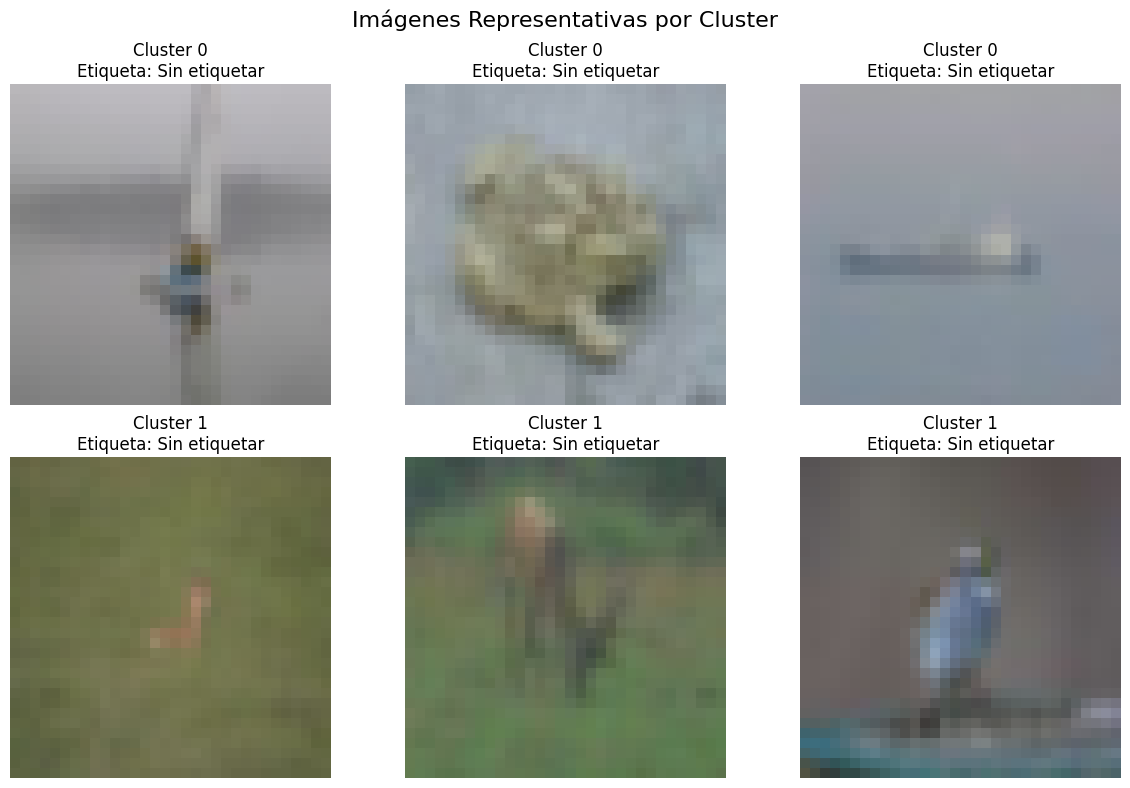


¡Clustering completado!
- Se crearon 2 clusters
- Se generó visualización 2D de la agrupación
- Se identificaron las imágenes más representativas de cada cluster
- Listo para el etiquetado manual (Aprendizaje Activo)


In [4]:
# PARTE 4: APLICACIÓN DE K-MEANS Y AGRUPACIÓN

K_ELEGIDO = 2  

print(f"Aplicando K-means con K = {K_ELEGIDO}...")

def aplicar_kmeans_completo(X, k):
    """
    Aplica K-means a todo el dataset
    """
    print(f"Ejecutando K-means con K={k} en {len(X)} imágenes...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    etiquetas = kmeans.fit_predict(X)
    
    return kmeans, etiquetas

def encontrar_imagenes_representativas(X, etiquetas, kmeans, imagenes_originales, n_por_cluster=3):
    """
    Encuentra las imágenes más representativas de cada cluster
    """
    centros = kmeans.cluster_centers_
    imagenes_representativas = {}
    indices_representativos = {}
    
    for cluster_id in range(len(centros)):
        # Encontrar imágenes en este cluster
        indices_cluster = np.where(etiquetas == cluster_id)[0]
        
        if len(indices_cluster) == 0:
            continue
            
        # Calcular distancias al centro del cluster
        X_cluster = X[indices_cluster]
        distancias = cdist(X_cluster, [centros[cluster_id]], metric='euclidean').flatten()
        
        # Obtener los índices de las imágenes más cercanas al centro
        indices_cercanos = np.argsort(distancias)[:n_por_cluster]
        indices_originales = indices_cluster[indices_cercanos]
        
        imagenes_representativas[cluster_id] = [imagenes_originales[i] for i in indices_originales]
        indices_representativos[cluster_id] = indices_originales
    
    return imagenes_representativas, indices_representativos

def visualizar_clusters(imagenes_representativas, etiquetas_clusters):
    """
    Visualiza las imágenes representativas de cada cluster
    """
    n_clusters = len(imagenes_representativas)
    n_imagenes_por_cluster = len(list(imagenes_representativas.values())[0])
    
    fig, axes = plt.subplots(n_clusters, n_imagenes_por_cluster, 
                            figsize=(4*n_imagenes_por_cluster, 4*n_clusters))
    
    if n_clusters == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Imágenes Representativas por Cluster', fontsize=16)
    
    for cluster_id in range(n_clusters):
        for img_idx in range(n_imagenes_por_cluster):
            if cluster_id < len(axes) and img_idx < len(axes[cluster_id]):
                ax = axes[cluster_id, img_idx]
                
                # Preparar imagen para visualización
                img = imagenes_representativas[cluster_id][img_idx].transpose(1, 2, 0)
                img = (img + 1) / 2  # Desnormalizar
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                ax.set_title(f'Cluster {cluster_id}\nEtiqueta: {etiquetas_clusters.get(cluster_id, "Sin etiquetar")}')
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def mostrar_estadisticas_clusters(etiquetas):
    """
    Muestra estadísticas de los clusters
    """
    conteo_clusters = Counter(etiquetas)
    
    print(f"\n=== ESTADÍSTICAS DE CLUSTERING ===")
    print(f"Número total de imágenes: {len(etiquetas)}")
    print(f"Número de clusters: {len(conteo_clusters)}")
    
    print("\nDistribución por cluster:")
    for cluster_id in sorted(conteo_clusters.keys()):
        porcentaje = (conteo_clusters[cluster_id] / len(etiquetas)) * 100
        print(f"Cluster {cluster_id}: {conteo_clusters[cluster_id]} imágenes ({porcentaje:.1f}%)")

def visualizar_clusters_2d(X_preparado, etiquetas, kmeans, n_muestras=5000):
    """
    Visualiza los clusters en un plano 2D usando PCA
    """
    print("\nGenerando visualización 2D de los clusters...")
    
    # Seleccionar una muestra para visualización (para mejor rendimiento)
    if len(X_preparado) > n_muestras:
        indices_viz = random.sample(range(len(X_preparado)), n_muestras)
        X_viz = X_preparado[indices_viz]
        etiquetas_viz = etiquetas[indices_viz]
    else:
        X_viz = X_preparado
        etiquetas_viz = etiquetas
    
    # Reducir a 2D con PCA
    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X_viz)
    
    # Crear gráfico
    plt.figure(figsize=(12, 10))
    
    # Colores para los clusters
    colores = plt.cm.Set1(np.linspace(0, 1, len(np.unique(etiquetas))))
    
    # Graficar cada cluster
    for i, cluster_id in enumerate(np.unique(etiquetas_viz)):
        indices_cluster = etiquetas_viz == cluster_id
        plt.scatter(X_2d[indices_cluster, 0], X_2d[indices_cluster, 1], 
                   c=[colores[i]], label=f'Cluster {cluster_id}', 
                   alpha=0.6, s=10)
    
    # Obtener centros en 2D
    centros_2d = pca_2d.transform(kmeans.cluster_centers_)
    
    # Marcar centros de clusters
    plt.scatter(centros_2d[:, 0], centros_2d[:, 1], 
               c='black', marker='x', s=200, linewidths=3, 
               label='Centros de Clusters')
    
    plt.xlabel(f'Primera Componente Principal ({pca_2d.explained_variance_ratio_[0]:.1%} varianza)')
    plt.ylabel(f'Segunda Componente Principal ({pca_2d.explained_variance_ratio_[1]:.1%} varianza)')
    plt.title(f'Visualización 2D de Clusters K-means (K={len(np.unique(etiquetas))})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Información adicional
    varianza_total = pca_2d.explained_variance_ratio_.sum()
    plt.figtext(0.02, 0.02, f'Varianza explicada total: {varianza_total:.1%}', 
                fontsize=10, ha='left')
    plt.figtext(0.02, 0.05, f'Muestra visualizada: {len(X_viz):,} imágenes', 
                fontsize=10, ha='left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Varianza explicada por las 2 componentes principales: {varianza_total:.1%}")

# Aplicar K-means al dataset completo
kmeans_modelo, etiquetas_kmeans = aplicar_kmeans_completo(X_preparado, K_ELEGIDO)

# Mostrar estadísticas
mostrar_estadisticas_clusters(etiquetas_kmeans)

# Visualizar clusters en 2D
visualizar_clusters_2d(X_preparado, etiquetas_kmeans, kmeans_modelo)

# Encontrar imágenes representativas
print("\nEncontrando imágenes representativas de cada cluster...")
imagenes_repr, indices_repr = encontrar_imagenes_representativas(
    X_preparado, etiquetas_kmeans, kmeans_modelo, images_mejoradas, n_por_cluster=3
)

# Inicializar diccionario de etiquetas (se llenará en la siguiente parte)
etiquetas_clusters = {}

# Visualizar clusters
print("\nVisualizando clusters...")
visualizar_clusters(imagenes_repr, etiquetas_clusters)

print(f"\n¡Clustering completado!")
print(f"- Se crearon {K_ELEGIDO} clusters")
print(f"- Se generó visualización 2D de la agrupación")
print(f"- Se identificaron las imágenes más representativas de cada cluster")
print(f"- Listo para el etiquetado manual (Aprendizaje Activo)")

¡Hora de etiquetar los clusters!
Observa cuidadosamente las imágenes representativas de cada cluster
y asigna etiquetas descriptivas según tu criterio
=== ETIQUETADO INTERACTIVO DE CLUSTERS ===
Vas a etiquetar cada cluster según tu criterio personal
Ejemplos de etiquetas: 'peludo', 'negro', 'rojo', 'mamifero', 'vehiculo', etc.
Presiona Enter sin escribir nada para terminar el etiquetado

=== CLUSTER 0 ===
Imágenes representativas:


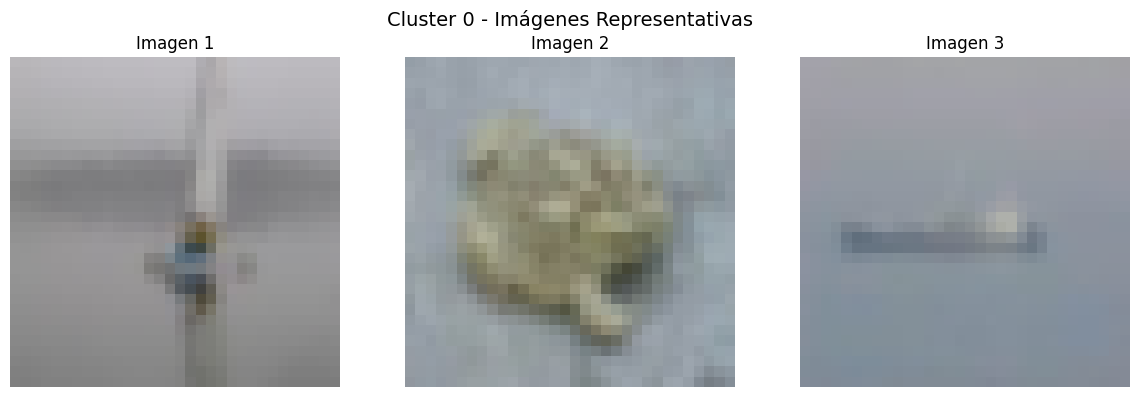

✓ Cluster 0 etiquetado como: 'plomo'

=== CLUSTER 1 ===
Imágenes representativas:


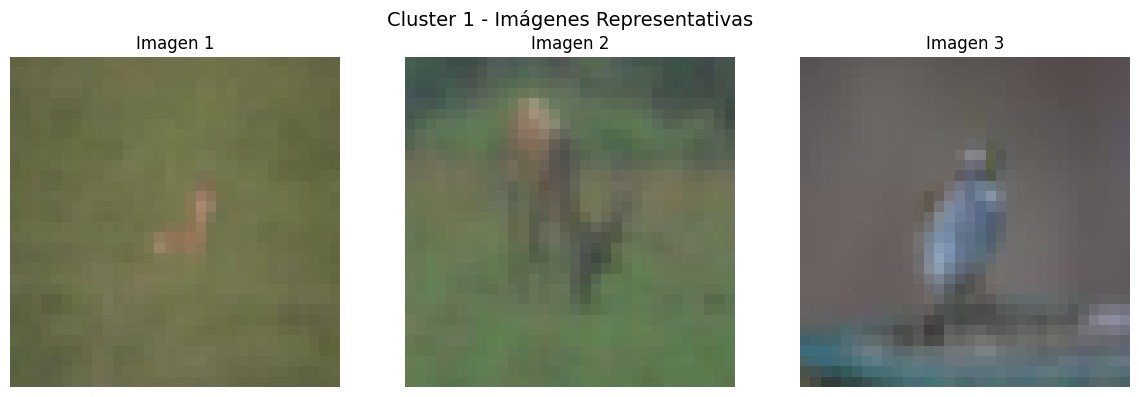

✓ Cluster 1 etiquetado como: 'verde'

=== APLICANDO ETIQUETAS PERSONALIZADAS AL DATASET ===
Mapeo de etiquetas:
  0: verde
  1: plomo

Estadísticas del etiquetado:
  verde: 28365 imágenes (56.7%)
  plomo: 21635 imágenes (43.3%)

=== VISUALIZACIÓN DEL DATASET ETIQUETADO ===


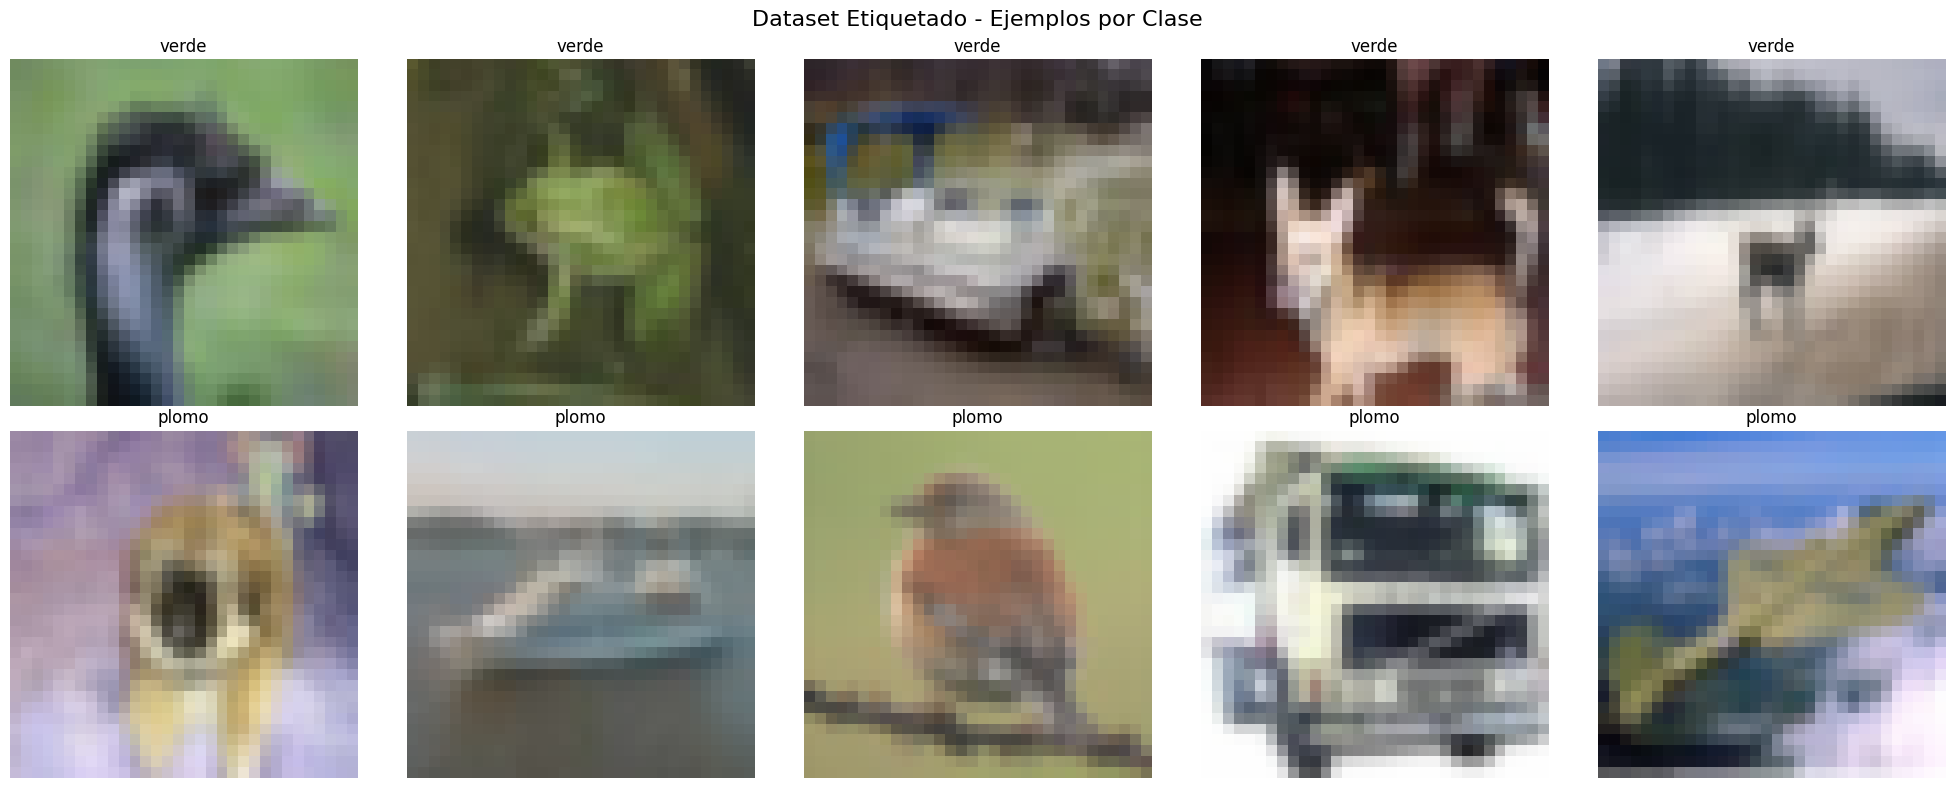


¡Etiquetado completado!
Dataset listo para entrenamiento supervisado
Total de clases: 2


In [5]:
# PARTE 5: APRENDIZAJE ACTIVO - ETIQUETADO MANUAL

def mostrar_cluster_para_etiquetado(cluster_id, imagenes_repr):
    """
    Muestra las imágenes representativas de un cluster para etiquetado
    """
    if cluster_id not in imagenes_repr:
        print(f"Cluster {cluster_id} no encontrado")
        return
    
    print(f"\n=== CLUSTER {cluster_id} ===")
    print("Imágenes representativas:")
    
    # Mostrar imágenes
    n_imagenes = len(imagenes_repr[cluster_id])
    fig, axes = plt.subplots(1, n_imagenes, figsize=(4*n_imagenes, 4))
    
    if n_imagenes == 1:
        axes = [axes]
    
    for i, img in enumerate(imagenes_repr[cluster_id]):
        # Preparar imagen para visualización
        img_vis = img.transpose(1, 2, 0)
        img_vis = (img_vis + 1) / 2  # Desnormalizar
        img_vis = np.clip(img_vis, 0, 1)
        
        axes[i].imshow(img_vis)
        axes[i].set_title(f'Imagen {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(f'Cluster {cluster_id} - Imágenes Representativas', fontsize=14)
    plt.tight_layout()
    plt.show()

def etiquetar_cluster_interactivo():
    """
    Función interactiva para etiquetar clusters
    """
    etiquetas_personalizadas = {}
    
    print("=== ETIQUETADO INTERACTIVO DE CLUSTERS ===")
    print("Vas a etiquetar cada cluster según tu criterio personal")
    print("Ejemplos de etiquetas: 'peludo', 'negro', 'rojo', 'mamifero', 'vehiculo', etc.")
    print("Presiona Enter sin escribir nada para terminar el etiquetado")
    
    for cluster_id in sorted(imagenes_repr.keys()):
        mostrar_cluster_para_etiquetado(cluster_id, imagenes_repr)
        
        while True:
            etiqueta = input(f"\n¿Cómo etiquetarías el Cluster {cluster_id}? (o Enter para saltar): ").strip()
            
            if etiqueta == "":
                print(f"Cluster {cluster_id} no etiquetado")
                break
            elif etiqueta.lower() in ['salir', 'exit', 'terminar']:
                print("Etiquetado terminado por el usuario")
                return etiquetas_personalizadas
            else:
                etiquetas_personalizadas[cluster_id] = etiqueta
                print(f"✓ Cluster {cluster_id} etiquetado como: '{etiqueta}'")
                break
    
    return etiquetas_personalizadas

def aplicar_etiquetas_a_dataset(etiquetas_kmeans, etiquetas_personalizadas):
    """
    Aplica las etiquetas personalizadas a todo el dataset
    """
    print("\n=== APLICANDO ETIQUETAS PERSONALIZADAS AL DATASET ===")
    
    # Crear mapeo de etiquetas personalizadas a números
    etiquetas_unicas = list(set(etiquetas_personalizadas.values()))
    etiqueta_a_numero = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}
    numero_a_etiqueta = {i: etiqueta for etiqueta, i in etiqueta_a_numero.items()}
    
    print("Mapeo de etiquetas:")
    for etiqueta, numero in etiqueta_a_numero.items():
        print(f"  {numero}: {etiqueta}")
    
    # Crear array de etiquetas finales
    etiquetas_finales = np.full(len(etiquetas_kmeans), -1)  # -1 para no etiquetado
    
    for cluster_id, etiqueta_texto in etiquetas_personalizadas.items():
        # Encontrar todas las imágenes de este cluster
        indices_cluster = np.where(etiquetas_kmeans == cluster_id)[0]
        # Asignar la etiqueta numérica correspondiente
        etiquetas_finales[indices_cluster] = etiqueta_a_numero[etiqueta_texto]
    
    # Estadísticas
    print(f"\nEstadísticas del etiquetado:")
    for numero, etiqueta in numero_a_etiqueta.items():
        count = np.sum(etiquetas_finales == numero)
        porcentaje = (count / len(etiquetas_finales)) * 100
        print(f"  {etiqueta}: {count} imágenes ({porcentaje:.1f}%)")
    
    no_etiquetadas = np.sum(etiquetas_finales == -1)
    if no_etiquetadas > 0:
        porcentaje_no_etiquetadas = (no_etiquetadas / len(etiquetas_finales)) * 100
        print(f"  Sin etiquetar: {no_etiquetadas} imágenes ({porcentaje_no_etiquetadas:.1f}%)")
    
    return etiquetas_finales, numero_a_etiqueta, etiqueta_a_numero

def visualizar_dataset_etiquetado(imagenes, etiquetas_finales, numero_a_etiqueta, n_por_clase=5):
    """
    Visualiza el dataset etiquetado
    """
    print("\n=== VISUALIZACIÓN DEL DATASET ETIQUETADO ===")
    
    # Obtener etiquetas únicas (excluyendo -1)
    etiquetas_unicas = [i for i in numero_a_etiqueta.keys()]
    
    fig, axes = plt.subplots(len(etiquetas_unicas), n_por_clase, 
                            figsize=(4*n_por_clase, 4*len(etiquetas_unicas)))
    
    if len(etiquetas_unicas) == 1:
        axes = axes.reshape(1, -1)
    
    for i, etiqueta_num in enumerate(etiquetas_unicas):
        # Encontrar imágenes con esta etiqueta
        indices_etiqueta = np.where(etiquetas_finales == etiqueta_num)[0]
        
        # Seleccionar aleatoriamente n_por_clase imágenes
        if len(indices_etiqueta) >= n_por_clase:
            indices_seleccionados = random.sample(list(indices_etiqueta), n_por_clase)
        else:
            indices_seleccionados = list(indices_etiqueta)
        
        for j in range(n_por_clase):
            ax = axes[i, j] if len(etiquetas_unicas) > 1 else axes[j]
            
            if j < len(indices_seleccionados):
                # Mostrar imagen
                img = imagenes[indices_seleccionados[j]].transpose(1, 2, 0)
                img = (img + 1) / 2  # Desnormalizar
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                ax.set_title(f'{numero_a_etiqueta[etiqueta_num]}')
            else:
                ax.axis('off')
            
            ax.axis('off')
    
    plt.suptitle('Dataset Etiquetado - Ejemplos por Clase', fontsize=16)
    plt.tight_layout()
    plt.show()

# Ejecutar etiquetado interactivo
print("¡Hora de etiquetar los clusters!")
print("Observa cuidadosamente las imágenes representativas de cada cluster")
print("y asigna etiquetas descriptivas según tu criterio")

# Etiquetado manual
etiquetas_personalizadas = etiquetar_cluster_interactivo()

# Aplicar etiquetas al dataset completo
if etiquetas_personalizadas:
    etiquetas_finales, numero_a_etiqueta, etiqueta_a_numero = aplicar_etiquetas_a_dataset(
        etiquetas_kmeans, etiquetas_personalizadas
    )
    
    # Actualizar el diccionario de etiquetas de clusters
    etiquetas_clusters.update(etiquetas_personalizadas)
    
    # Visualizar resultado
    visualizar_dataset_etiquetado(images_mejoradas, etiquetas_finales, numero_a_etiqueta)
    
    print("\n¡Etiquetado completado!")
    print(f"Dataset listo para entrenamiento supervisado")
    print(f"Total de clases: {len(numero_a_etiqueta)}")
    
else:
    print("No se realizó etiquetado. Continuando sin etiquetas personalizadas...")
    etiquetas_finales = None
    numero_a_etiqueta = None
    etiqueta_a_numero = None

Preparando datos para entrenamiento...
Imágenes etiquetadas: 50000
Distribución de clases:
  verde: 28365 imágenes
  plomo: 21635 imágenes

División de datos:
  Entrenamiento: 35000 imágenes
  Validación: 5000 imágenes
  Prueba: 10000 imágenes

Modelo creado:
  Clases: 2
  Parámetros entrenables: 1,274,626
Iniciando entrenamiento...
Época 1/30:
  Train Loss: 0.1570, Train Acc: 93.42%
  Val Loss: 0.0809, Val Acc: 96.82%
  LR: 0.001000
Época 6/30:
  Train Loss: 0.0761, Train Acc: 96.95%
  Val Loss: 0.0461, Val Acc: 98.10%
  LR: 0.001000
Época 11/30:
  Train Loss: 0.0613, Train Acc: 97.73%
  Val Loss: 0.1409, Val Acc: 96.08%
  LR: 0.001000
Época 16/30:
  Train Loss: 0.0353, Train Acc: 98.61%
  Val Loss: 0.0360, Val Acc: 98.36%
  LR: 0.000500
Época 21/30:
  Train Loss: 0.0276, Train Acc: 98.94%
  Val Loss: 0.0372, Val Acc: 98.72%
  LR: 0.000500
Época 26/30:
  Train Loss: 0.0234, Train Acc: 99.09%
  Val Loss: 0.0514, Val Acc: 98.32%
  LR: 0.000500
Época 30/30:
  Train Loss: 0.0232, Train Ac

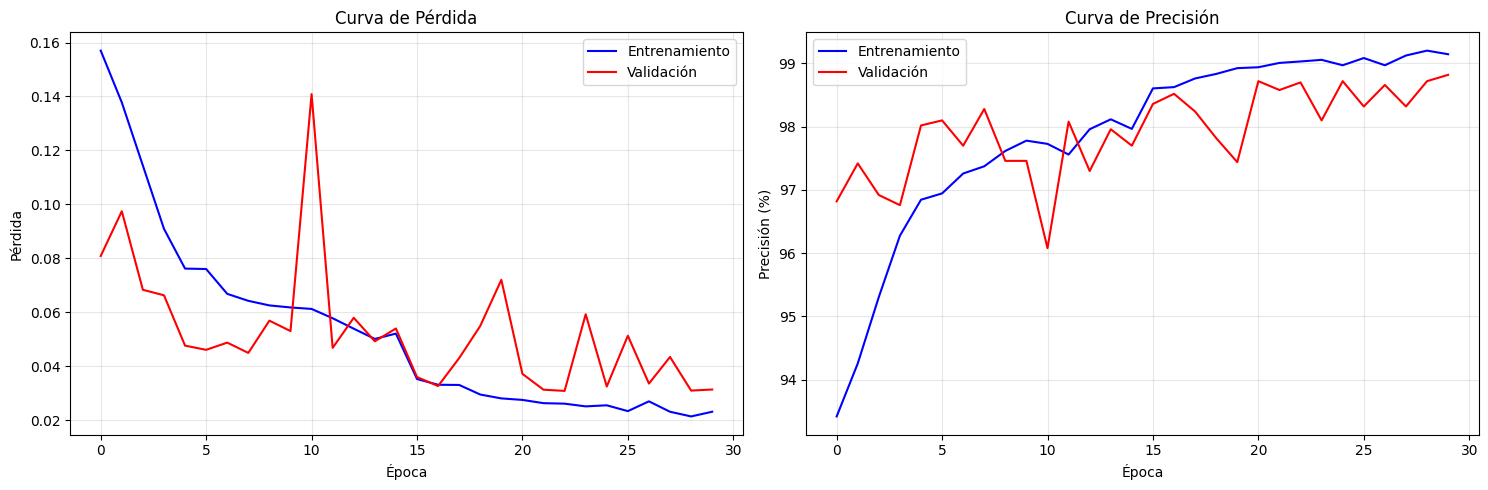


¡Entrenamiento completado!
Procede a la Parte 7 para evaluar el modelo.


In [10]:
# PARTE 6: ENTRENAMIENTO Y EVALUACIÓN SUPERVISADA

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# Verificar que tenemos etiquetas
if 'etiquetas_finales' not in locals() or etiquetas_finales is None:
    print("⚠️ No se encontraron etiquetas personalizadas.")
    print("Ejecuta primero la Parte 5 para etiquetar los clusters.")
    exit()

def preparar_datos_entrenamiento(imagenes, etiquetas, test_size=0.2, val_size=0.1):
    """
    Prepara los datos para entrenamiento, validación y prueba
    """
    print("Preparando datos para entrenamiento...")
    
    # Filtrar imágenes sin etiquetar (etiqueta = -1)
    indices_etiquetados = np.where(etiquetas != -1)[0]
    imagenes_etiquetadas = imagenes[indices_etiquetados]
    etiquetas_etiquetadas = etiquetas[indices_etiquetados]
    
    print(f"Imágenes etiquetadas: {len(imagenes_etiquetadas)}")
    print(f"Distribución de clases:")
    for clase, nombre in numero_a_etiqueta.items():
        count = np.sum(etiquetas_etiquetadas == clase)
        print(f"  {nombre}: {count} imágenes")
    
    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        imagenes_etiquetadas, etiquetas_etiquetadas, 
        test_size=test_size, random_state=42, stratify=etiquetas_etiquetadas
    )
    
    # División train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, 
        test_size=val_size/(1-test_size), random_state=42, stratify=y_train
    )
    
    print(f"\nDivisión de datos:")
    print(f"  Entrenamiento: {len(X_train)} imágenes")
    print(f"  Validación: {len(X_val)} imágenes")
    print(f"  Prueba: {len(X_test)} imágenes")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def crear_datasets_pytorch(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Crea datasets y dataloaders de PyTorch
    """
    # Convertir a tensores de PyTorch
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train)
    y_val_tensor = torch.LongTensor(y_val)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Crear datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

# Definir arquitectura de la red neuronal
class CNN_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Classifier, self).__init__()
        
        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Capas fully connected
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 32x32 -> 16x16 -> 8x8 -> 4x4
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        # Convolucional 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Convolucional 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Convolucional 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

def entrenar_modelo(model, train_loader, val_loader, num_epochs=50, lr=0.001):
    """
    Entrena el modelo
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print("Iniciando entrenamiento...")
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calcular métricas
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Época {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {scheduler.get_last_lr()[0]:.6f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def graficar_entrenamiento(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Grafica las curvas de entrenamiento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Pérdida
    ax1.plot(train_losses, label='Entrenamiento', color='blue')
    ax1.plot(val_losses, label='Validación', color='red')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.set_title('Curva de Pérdida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Precisión
    ax2.plot(train_accuracies, label='Entrenamiento', color='blue')
    ax2.plot(val_accuracies, label='Validación', color='red')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión (%)')
    ax2.set_title('Curva de Precisión')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Preparar datos para entrenamiento
X_train, X_val, X_test, y_train, y_val, y_test = preparar_datos_entrenamiento(
    images_mejoradas, etiquetas_finales
)

# Crear dataloaders
train_loader, val_loader, test_loader = crear_datasets_pytorch(
    X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32
)

# Crear modelo
num_classes = len(numero_a_etiqueta)
model = CNN_Classifier(num_classes).to(device)

print(f"\nModelo creado:")
print(f"  Clases: {num_classes}")
print(f"  Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Entrenar modelo
train_losses, val_losses, train_accuracies, val_accuracies = entrenar_modelo(
    model, train_loader, val_loader, num_epochs=30, lr=0.001
)

# Graficar curvas de entrenamiento
graficar_entrenamiento(train_losses, val_losses, train_accuracies, val_accuracies)

print("\n¡Entrenamiento completado!")
print("Procede a la Parte 7 para evaluar el modelo.")

Iniciando evaluación final del modelo...
Evaluando modelo en conjunto de prueba...
               REPORTE DE EVALUACIÓN FINAL

🎯 MÉTRICAS GENERALES:
   Precisión (Accuracy): 98.46%
   Pérdida (Loss): 0.0519
   F1-Score Promedio: 0.9846
   Precisión Promedio: 0.9846
   Recall Promedio: 0.9846

📊 MÉTRICAS POR CLASE:
----------------------------------------------------------------------
Clase           Precisión    Recall       F1-Score     Muestras  
----------------------------------------------------------------------
verde           0.9864       0.9864       0.9864       5673      
plomo           0.9822       0.9822       0.9822       4327      
----------------------------------------------------------------------

📈 Generando matriz de confusión...


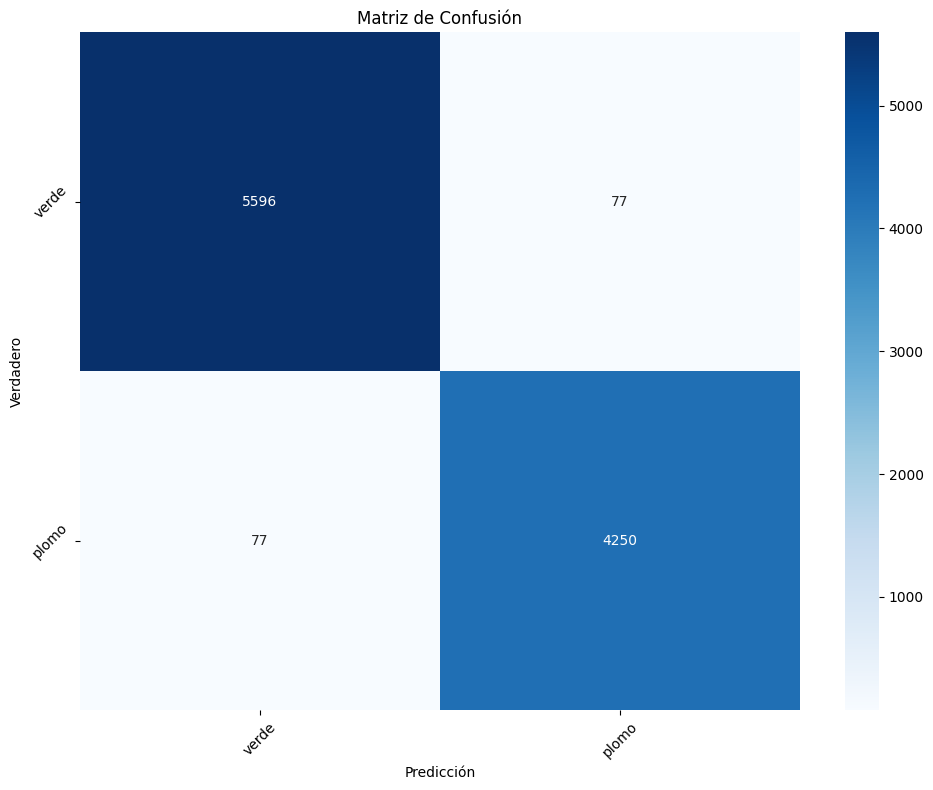


🖼️ Ejemplos de predicciones:


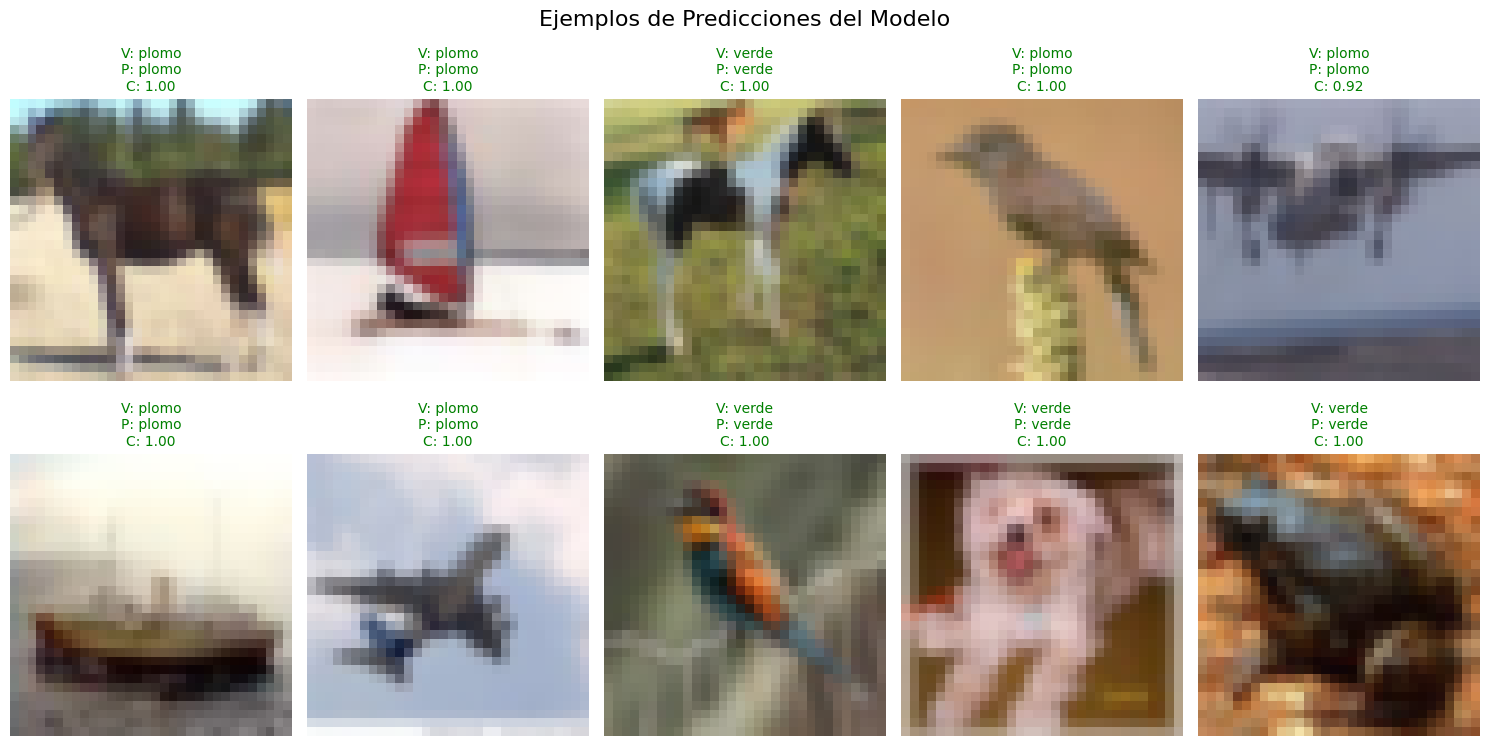


🔍 ANÁLISIS DE ERRORES:
   Total de errores: 154
   Errores más comunes:
     1. plomo → verde: 77 veces
     2. verde → plomo: 77 veces

💾 Modelo guardado como: modelo_semi_supervisado.pth

                    RESUMEN FINAL
✅ Proceso de aprendizaje semi-supervisado completado
📊 Dataset: 50,000 imágenes de CIFAR-10
🏷️ Etiquetas personalizadas: 2 clases
🎯 Precisión final: 98.46%
📈 F1-Score: 0.9846
💾 Modelo guardado y listo para uso
🎉 ¡Excelente rendimiento del modelo!


In [7]:
# PARTE 7: EVALUACIÓN FINAL DEL MODELO

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

def evaluar_modelo(model, test_loader, numero_a_etiqueta):
    """
    Evalúa el modelo en el conjunto de prueba
    """
    model.eval()
    
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    print("Evaluando modelo en conjunto de prueba...")
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calcular métricas
    test_accuracy = 100. * correct / total
    test_loss_avg = test_loss / len(test_loader)
    
    # Métricas detalladas por clase
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_predictions, average=None, zero_division=0
    )
    
    # Métricas promedio
    precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': test_accuracy,
        'loss': test_loss_avg,
        'predictions': all_predictions,
        'targets': all_targets,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'precision_avg': precision_avg,
        'recall_avg': recall_avg,
        'f1_avg': f1_avg
    }

def mostrar_reporte_evaluacion(resultados, numero_a_etiqueta):
    """
    Muestra un reporte detallado de la evaluación
    """
    print("="*60)
    print("               REPORTE DE EVALUACIÓN FINAL")
    print("="*60)
    
    print(f"\n🎯 MÉTRICAS GENERALES:")
    print(f"   Precisión (Accuracy): {resultados['accuracy']:.2f}%")
    print(f"   Pérdida (Loss): {resultados['loss']:.4f}")
    print(f"   F1-Score Promedio: {resultados['f1_avg']:.4f}")
    print(f"   Precisión Promedio: {resultados['precision_avg']:.4f}")
    print(f"   Recall Promedio: {resultados['recall_avg']:.4f}")
    
    print(f"\n📊 MÉTRICAS POR CLASE:")
    print("-" * 70)
    print(f"{'Clase':<15} {'Precisión':<12} {'Recall':<12} {'F1-Score':<12} {'Muestras':<10}")
    print("-" * 70)
    
    for i in range(len(numero_a_etiqueta)):
        clase_nombre = numero_a_etiqueta[i]
        precision = resultados['precision'][i]
        recall = resultados['recall'][i]
        f1 = resultados['f1'][i]
        support = resultados['support'][i]
        
        print(f"{clase_nombre:<15} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<10}")
    
    print("-" * 70)

def crear_matriz_confusion(targets, predictions, numero_a_etiqueta):
    """
    Crea y visualiza la matriz de confusión
    """
    # Calcular matriz de confusión
    cm = confusion_matrix(targets, predictions)
    
    # Crear etiquetas
    etiquetas = [numero_a_etiqueta[i] for i in range(len(numero_a_etiqueta))]
    
    # Visualizar
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cm

def mostrar_predicciones_ejemplo(model, X_test, y_test, numero_a_etiqueta, n_ejemplos=10):
    """
    Muestra ejemplos de predicciones del modelo
    """
    model.eval()
    
    # Seleccionar ejemplos aleatorios
    indices = random.sample(range(len(X_test)), n_ejemplos)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    fig.suptitle('Ejemplos de Predicciones del Modelo', fontsize=16)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Preparar imagen para predicción
            imagen_tensor = torch.FloatTensor(X_test[idx]).unsqueeze(0).to(device)
            
            # Hacer predicción
            output = model(imagen_tensor)
            _, prediccion = torch.max(output, 1)
            confianza = F.softmax(output, dim=1).max().item()
            
            # Mostrar imagen
            ax = axes[i // 5, i % 5]
            img = X_test[idx].transpose(1, 2, 0)
            img = (img + 1) / 2  # Desnormalizar
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            
            # Etiquetas
            verdadero = numero_a_etiqueta[y_test[idx]]
            predicho = numero_a_etiqueta[prediccion.item()]
            
            # Color del título según si es correcto o no
            color = 'green' if verdadero == predicho else 'red'
            ax.set_title(f'V: {verdadero}\nP: {predicho}\nC: {confianza:.2f}', 
                        color=color, fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def analizar_errores(targets, predictions, numero_a_etiqueta):
    """
    Analiza los tipos de errores más comunes
    """
    print("\n🔍 ANÁLISIS DE ERRORES:")
    
    # Encontrar errores
    errores = []
    for i, (verdadero, predicho) in enumerate(zip(targets, predictions)):
        if verdadero != predicho:
            errores.append({
                'indice': i,
                'verdadero': numero_a_etiqueta[verdadero],
                'predicho': numero_a_etiqueta[predicho]
            })
    
    if not errores:
        print("   ¡Sin errores! Precisión perfecta.")
        return
    
    # Contar tipos de errores
    from collections import defaultdict
    conteo_errores = defaultdict(int)
    
    for error in errores:
        par_error = f"{error['verdadero']} → {error['predicho']}"
        conteo_errores[par_error] += 1
    
    # Mostrar errores más comunes
    errores_ordenados = sorted(conteo_errores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"   Total de errores: {len(errores)}")
    print(f"   Errores más comunes:")
    
    for i, (par_error, cantidad) in enumerate(errores_ordenados[:5]):
        print(f"     {i+1}. {par_error}: {cantidad} veces")

def guardar_modelo(model, numero_a_etiqueta, nombre_archivo='modelo_semi_supervisado.pth'):
    """
    Guarda el modelo entrenado
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'numero_a_etiqueta': numero_a_etiqueta,
        'num_classes': len(numero_a_etiqueta)
    }
    
    torch.save(checkpoint, nombre_archivo)
    print(f"\n💾 Modelo guardado como: {nombre_archivo}")

# Evaluar el modelo
print("Iniciando evaluación final del modelo...")
resultados = evaluar_modelo(model, test_loader, numero_a_etiqueta)

# Mostrar reporte completo
mostrar_reporte_evaluacion(resultados, numero_a_etiqueta)

# Crear matriz de confusión
print("\n📈 Generando matriz de confusión...")
matriz_confusion = crear_matriz_confusion(
    resultados['targets'], resultados['predictions'], numero_a_etiqueta
)

# Mostrar ejemplos de predicciones
print("\n🖼️ Ejemplos de predicciones:")
mostrar_predicciones_ejemplo(model, X_test, y_test, numero_a_etiqueta)

# Analizar errores
analizar_errores(resultados['targets'], resultados['predictions'], numero_a_etiqueta)

# Guardar modelo
guardar_modelo(model, numero_a_etiqueta)

# Resumen final
print("\n" + "="*60)
print("                    RESUMEN FINAL")
print("="*60)
print(f"✅ Proceso de aprendizaje semi-supervisado completado")
print(f"📊 Dataset: {len(images_mejoradas):,} imágenes de CIFAR-10")
print(f"🏷️ Etiquetas personalizadas: {len(numero_a_etiqueta)} clases")
print(f"🎯 Precisión final: {resultados['accuracy']:.2f}%")
print(f"📈 F1-Score: {resultados['f1_avg']:.4f}")
print(f"💾 Modelo guardado y listo para uso")
print("="*60)

if resultados['accuracy'] >= 70:
    print("🎉 ¡Excelente rendimiento del modelo!")
elif resultados['accuracy'] >= 50:
    print("👍 Buen rendimiento del modelo")
else:
    print("⚠️ El modelo podría necesitar más ajustes")
    print("   Sugerencias:")
    print("   - Más épocas de entrenamiento")
    print("   - Ajustar hiperparámetros")
    print("   - Más datos de entrenamiento")
    print("   - Data augmentation")